# Прогноз оттока клиентов «Бета-Банка»

# Описание проекта

Цель -  спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Необходимо построить модель с предельно большим значением F1-меры. Минимально допустимое значение метрики 0.59

# Описание данных

### Признаки:  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — количество недвижимости у клиента  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  
### Целевой признак:  
Exited — факт ухода клиента  

## Содержание проекта

[1. Загрузка и подготовка данных](#1)  
+ [1.1 Предварительная подготовка данных](#1.1)  
    + [1.1.1 Кодирование признаков](#1.1.1)  
    + [1.1.2 Обработка пропусков](#1.1.2)  
    + [1.1.3 Масштабирование признаков](#1.1.3)  
+ [Вывод](#end_1)  

[2. Исследование задачи](#2)  
+ [2.1 Исследование баланса классов](#2.1)  
+ [2.2 Построение моделей без балансировки классов](#2.2) 
+ [Вывод](#end_2)  

[3. Улучшение качества модели](#3)  
+ [3.1 Weight tuning](#3.1)  
+ [3.2 Upsampling](#3.2)  
+ [3.3 Downsampling](#3.3)  
+ [3.4 Агрегирование предварительных результатов](#3.4)  
+ [3.5 Изменение порога](#3.4)  
+ [Вывод](#end_3) 

[4. Тестирование модели](#4)  
[5. Общий вывод](#5)  

## 1. Загрузка и подготовка данных<a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier


from catboost import CatBoostClassifier
from xgboost import XGBClassifier
#from sklearn import cross_validation

from sklearn.utils import shuffle


import random

import warnings


In [3]:
display(churn.head())
display(churn.info())
display(churn.describe())
display(churn['Exited'].value_counts())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


0    7963
1    2037
Name: Exited, dtype: int64

### Проведем предварительную подготовку данных:<a id="1.1"></a>
+ удалим столбец `Surname`, т.к. он избыточен и не представляет ценности, для идентификации клиента достаточно его ID;
+ преобразуем категориальные признаки `Geography` и `Gender` в количественные, используя технику прямого кодирования (One-Hot Encoding, OHE);  
+ заполним пустые значения столбца `Tenure`
+ проведем стандартизацию признаков


In [4]:
churn = churn.drop('Surname', axis = 1)

### Кодирование признаков<a id="1.1.1"></a>

In [5]:
# OHE
churn_ohe = pd.get_dummies(churn, drop_first=True)


In [6]:
display(churn_ohe.head())

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Обработка пропусков<a id="1.1.2"></a>

Проанализируем структуру значений столбца `Tenure`:

In [7]:
churn_ohe['Tenure'].value_counts(dropna = False, normalize=True)

1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: Tenure, dtype: float64

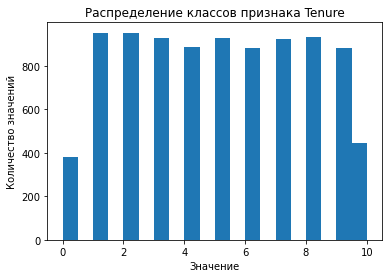

In [8]:
churn_ohe['Tenure'].plot(kind = 'hist', bins = 20)
plt.title('Распределение классов признака Tenure')
plt.xlabel("Значение")
plt.ylabel("Количество значений")
plt.show()

По гистограмме можно сделать предположение, что, т.к.  классы 1-9 распределены практически равномерно, то и классы 0, 10, вероятно, должны быть распределены аналогичным образом.  
Т.о. самым простым решением было бы поделить пополам случайным образом пустые 909 значений между 0 и 10 классом ("базовый вариант").  

В качестве эксперимента, попробуем заполнить пустые значения через регрессионную и классификационную модели, оценим насколько результат будет отличаться от "базового".

Оценим корреляционные зависимости между параметрами:

In [9]:
display(churn.loc[:, ['Tenure', 'CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']].corr())

,Tenure,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary
Tenure,1.000000,-0.000062,-0.013134,-0.007911,0.011979,0.010520
CreditScore,-0.000062,1.000000,-0.003965,0.006268,0.012238,-0.001384
Age,-0.013134,-0.003965,1.000000,0.028308,-0.030680,-0.007201
Balance,-0.007911,0.006268,0.028308,1.000000,-0.304180,0.012797
NumOfProducts,0.011979,0.012238,-0.030680,-0.304180,1.000000,0.014204
EstimatedSalary,0.010520,-0.001384,-0.007201,0.012797,0.014204,1.000000


Видим, что зависимости между нашим целевым признаком `Tenure` и прочими признаками практически отсутствует.

In [10]:
# Разделим выборку на 2 части, с Nan в столбце `Tenure` и без
churn_nan = churn_ohe.query('Tenure != Tenure')
churn_notnan =  churn_ohe.query('Tenure == Tenure')

### Эксперимент с моделью классификации

Из части общего датасета с отсутствующими Nan, создадим выборку со значениями `Tenure`, равными 0 и 10, т.е. работать будем только с этой частью выборки, сведя т.о. задачу к задаче бинарной классификации.  В случае, если модель покажет приемлемый результат, заполним с ее помощью пустые значения, распределив их между этими двумя классами.
Разделим далее эту выборку на обучающую и валидационную. 

In [11]:
churn_0_10 = churn_notnan.query('Tenure == 10 or Tenure == 0')
display(churn_0_10['Tenure'].value_counts())

10.0    446
0.0     382
Name: Tenure, dtype: int64

Разделим нашу выборку и обучим модель Логистической регрессии.

In [12]:
target = churn_0_10['Tenure']
features = churn_0_10.drop(['Tenure', 'RowNumber', 'CustomerId', 'Exited'], axis = 1)

In [13]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target,  test_size = 0.25, random_state = 12345)

In [14]:
model = LogisticRegression(random_state=12345, class_weight='balanced') 
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid)
print(classification_report(target_valid, predictions_valid))

              precision    recall  f1-score   support

         0.0       0.45      0.48      0.46        96
        10.0       0.52      0.49      0.50       111

    accuracy                           0.48       207
   macro avg       0.48      0.48      0.48       207
weighted avg       0.49      0.48      0.48       207



Результаты неудовлетворительны.  Результат соответствует результату случайной модели.
Практически аналогичные результаты получаются и на других моделях классификации на основе деревьев, вне зависимости от того, произведено масштабирование (стандартизация) признаков или нет.

### Эксперимент с регрессионной моделью

Разделим нашу выборку и обучим модель Линейной регрессии.

In [15]:
target = churn_notnan['Tenure']
features = churn_notnan.drop(['Tenure', 'RowNumber', 'CustomerId', 'Exited'], axis = 1)

In [16]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target,  test_size = 0.25, random_state = 12345)

In [17]:
model = LinearRegression() 
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid) 

result = (mean_squared_error(target_valid, predictions_valid)) ** 0.5 
print('Значение R2:', model.score(features_valid, target_valid))


Значение R2: -0.0027967554012051643


Результаты также неудовлетворительны, значение метрики R2 ниже нуля, это значит , что ее предсказания хуже, чем случайная модель, с предсказанием средних значений.  
Аналогичные результаты получаются и на других регрессионных моделях на основе деревьев, вне зависимости от того, произведено масштабирование (стандартизация) признаков или нет.

Т.к. результаты моделирования оказались неудовлетворительны, заполним пустые значения произвольно 0 и 10.

In [18]:
def random_tenure(value):
    if value != value:
        return random.choice([0, 10])
    return value

In [19]:
# Проверочные строки
churn_ohe.loc[churn_ohe.loc[:, 'Tenure'] != churn_ohe.loc[:, 'Tenure']].head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
30,31,15589475,591,39,NaN,0.00,3,1,0,140469.38,1,0,1,0
48,49,15766205,550,38,NaN,103391.38,1,0,1,90878.13,0,1,0,1
51,52,15768193,585,36,NaN,146050.97,2,0,0,86424.57,0,1,0,1
53,54,15702298,655,41,NaN,125561.97,1,0,0,164040.94,1,1,0,1
60,61,15651280,742,35,NaN,136857.00,1,0,0,84509.57,0,1,0,1


In [20]:
# Заполняем
churn_ohe['Tenure'] = churn_ohe['Tenure'].apply(random_tenure)

In [21]:
# Проверяем
churn_ohe.loc[[30, 48, 51, 53, 60]]

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
30,31,15589475,591,39,0.0,0.00,3,1,0,140469.38,1,0,1,0
48,49,15766205,550,38,0.0,103391.38,1,0,1,90878.13,0,1,0,1
51,52,15768193,585,36,10.0,146050.97,2,0,0,86424.57,0,1,0,1
53,54,15702298,655,41,10.0,125561.97,1,0,0,164040.94,1,1,0,1
60,61,15651280,742,35,10.0,136857.00,1,0,0,84509.57,0,1,0,1


In [22]:
churn_ohe['Tenure'] = churn_ohe['Tenure'].astype('int64')
display(churn_ohe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int64  
 1   CustomerId         10000 non-null  int64  
 2   CreditScore        10000 non-null  int64  
 3   Age                10000 non-null  int64  
 4   Tenure             10000 non-null  int64  
 5   Balance            10000 non-null  float64
 6   NumOfProducts      10000 non-null  int64  
 7   HasCrCard          10000 non-null  int64  
 8   IsActiveMember     10000 non-null  int64  
 9   EstimatedSalary    10000 non-null  float64
 10  Exited             10000 non-null  int64  
 11  Geography_Germany  10000 non-null  uint8  
 12  Geography_Spain    10000 non-null  uint8  
 13  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(9), uint8(3)
memory usage: 888.8 KB


None

### Масштабирование признаков<a id="1.1.3"></a>

In [23]:
target = churn_ohe['Exited']
features = churn_ohe.drop(['Exited', 'RowNumber', 'CustomerId'], axis = 1)

In [24]:
# Выделим обучающую, валидационную и тестовую выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target,  test_size = 0.4, random_state = 12345)


In [25]:
features_test, features_valid, target_test, target_valid = train_test_split(features_valid_test, target_valid_test,  test_size = 0.5, random_state = 12345)


In [26]:
print(features_test.shape)
print(features_valid.shape)
print(features_train.shape)
print(target_test.shape)
print(target_valid.shape)
print(target_train.shape)

(2000, 11)
(2000, 11)
(6000, 11)
(2000,)
(2000,)
(6000,)


In [27]:
warnings.filterwarnings("ignore")
numeric = ['Tenure', 'CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,0.952842,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,0.952842,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.640095,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.315667,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.958683,1.140475,-0.891560,0,0,1.524268,1,0,0


## Вывод<a id="end_1"></a>

Произведена предварительная подготовка данных:  
+ проведено прямое кодирование категориальных признаков с помощью техники прямого кодирования (One-Hot Encoding, OHE)
+ заполнены пустые значения столбца `Tenure`, значениями 0,10 случайным порядком, предпринятые попытки заполнения пустых значений с помощью предиктивной модели, показали неудовлетворительные результаты
+ проведена стандартизация данных с помощью инструмента StandardScaller
    

# 2.Исследование задачи<a id="2"></a>

## 2.1 Исследование баланса классов<a id="2.1"></a>

In [28]:
churn_ohe['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Имеем 4 кратный дисбаланс классов, с которым далее будем работать.  
На текущем этапе обучим модели с имеющимся дисбалансом, для оценки его влияния на результат.

## 2.2 Построение моделей без балансировки классов<a id="2.2"></a>

Будем сравнивать модели логистической регрессии, случайного леса  и различные модели градиентного бустинга.  
Для всех моделей выставим соответствующее значение гиперпараметра, без балансировки классов. 

### Логистическая регрессия

In [29]:
model = LogisticRegression(random_state=12345, solver='liblinear') 

def measure_quality(model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    return f1, roc_auc, predictions_valid


f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)


scores_data_no_weight = pd.DataFrame()
tmp_scores_data = pd.DataFrame({'Model': ['LogisticRegression'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_no_weight = scores_data_no_weight.append(tmp_scores_data)



              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1577
           1       0.52      0.19      0.28       423

    accuracy                           0.79      2000
   macro avg       0.67      0.57      0.58      2000
weighted avg       0.75      0.79      0.75      2000

Значение F1: 0.2777777777777778
Значение AUC-ROC 0.7389528251115698


## Случайный лес

In [30]:
clf_rf = RandomForestClassifier(random_state=12345, class_weight=None)
parameters = {'n_estimators': range(27, 30, 2), 'max_depth': range(8, 10, 2), 'min_samples_split': range(7,9, 2), 'min_samples_leaf': range(1,3)}
grid = GridSearchCV(clf_rf, parameters, scoring = 'f1', cv=5)
grid.fit(features_train, target_train)
predictions_valid = grid.predict(features_valid)
print('Оптимальные параметры модели:', grid.best_params_)
print(classification_report(target_valid, predictions_valid))
f1 = f1_score(target_valid, predictions_valid)
print('Значение F1:', f1)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('Значение AUC-ROC', roc_auc)


tmp_scores_data = pd.DataFrame({'Model': ['RandomForestClassifier'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_no_weight = scores_data_no_weight.append(tmp_scores_data)


Оптимальные параметры модели: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 29}
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1577
           1       0.75      0.35      0.48       423

    accuracy                           0.84      2000
   macro avg       0.80      0.66      0.69      2000
weighted avg       0.83      0.84      0.81      2000

Значение F1: 0.4774193548387097
Значение AUC-ROC 0.7389528251115698


## GradientBoosting

В модели GradientBoostingClassifier нет гиперпараметра, отвечающего за баланс классов, поэтому будем использовать значения "по умолчанию".

In [31]:
model = GradientBoostingClassifier(random_state=12345) 
f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['GradientBoosting'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_no_weight = scores_data_no_weight.append(tmp_scores_data)


              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1577
           1       0.74      0.44      0.55       423

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.83      2000

Значение F1: 0.5505952380952381
Значение AUC-ROC 0.8640444570368072


## XGBoost

In [32]:
model = XGBClassifier(random_state=12345, booster= 'gbtree', verbosity = 0, scale_pos_weight = 1) 
f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['XGBoost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_no_weight = scores_data_no_weight.append(tmp_scores_data)


              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1577
           1       0.69      0.48      0.57       423

    accuracy                           0.84      2000
   macro avg       0.78      0.71      0.74      2000
weighted avg       0.83      0.84      0.83      2000

Значение F1: 0.5670391061452514
Значение AUC-ROC 0.8405417114520043


## Cat Boost

In [33]:
model = CatBoostClassifier(random_state=12345, class_weights=None) 
f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['Cat Boost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_no_weight = scores_data_no_weight.append(tmp_scores_data).reset_index(drop = True)

Learning rate set to 0.022141
0:	learn: 0.6746486	total: 70.1ms	remaining: 1m 10s
1:	learn: 0.6591499	total: 75.9ms	remaining: 37.9s
2:	learn: 0.6441119	total: 82.2ms	remaining: 27.3s
3:	learn: 0.6309510	total: 88.6ms	remaining: 22.1s
4:	learn: 0.6157399	total: 94.9ms	remaining: 18.9s
5:	learn: 0.6022219	total: 103ms	remaining: 17.1s
6:	learn: 0.5900668	total: 112ms	remaining: 15.9s
7:	learn: 0.5765509	total: 112ms	remaining: 15.9s
8:	learn: 0.5657583	total: 120ms	remaining: 14.9s
9:	learn: 0.5542654	total: 133ms	remaining: 14.6s
10:	learn: 0.5423471	total: 173ms	remaining: 17.1s
11:	learn: 0.5309575	total: 180ms	remaining: 16.2s
12:	learn: 0.5201985	total: 190ms	remaining: 15.7s
13:	learn: 0.5119808	total: 196ms	remaining: 14.9s
14:	learn: 0.5023956	total: 204ms	remaining: 14.4s
15:	learn: 0.4938135	total: 213ms	remaining: 14s
16:	learn: 0.4858975	total: 222ms	remaining: 13.6s
17:	learn: 0.4787758	total: 231ms	remaining: 13.3s
18:	learn: 0.4734177	total: 240ms	remaining: 13.1s
19:	lea

Сведем полученные значения F1, ROC_AUC от всех моделей в одну таблицу:

In [34]:
display(scores_data_no_weight)

,Model,F1,ROC_AUC
0,LogisticRegression,0.277778,0.738953
1,RandomForestClassifier,0.477419,0.738953
2,GradientBoosting,0.550595,0.864044
3,XGBoost,0.567039,0.840542
4,Cat Boost,0.557522,0.862773


## Вывод

Значения F1 меры, полученные без баланса классов неудовлетворительны по всем моделям, целевое значение меньше минимально необходимого 0.59 по условиям проекта, что говорит о необходимости такой балансировки. 
  
Балансировку классов проведем тремя способами:
+ Используя соответствующий гиперпараметр в каждой из моделей, при его наличии;
+ Проведем upsampling;
+ Проведем dawnsampling

# 3. Улучшение качества модели<a id="3"></a>

## 3.1 Weight tuning<a id="3.1"></a>

Для каждой модели проведем балансировку классов , используя значение соответствующих гиперпараметров.  
Сведем результаты F1 в общую таблицу и сравним результаты.

### Логистическая регрессия

In [35]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') 
f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

scores_data_weight = pd.DataFrame()
tmp_scores_data = pd.DataFrame({'Model': ['LogisticRegression'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_weight = scores_data_weight.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1577
           1       0.38      0.66      0.48       423

    accuracy                           0.70      2000
   macro avg       0.63      0.68      0.63      2000
weighted avg       0.78      0.70      0.72      2000

Значение F1: 0.4814495254529767
Значение AUC-ROC 0.7419764912580521


## Случайный лес

In [36]:
clf_rf = RandomForestClassifier(random_state=12345, class_weight='balanced')
parameters = {'n_estimators': range(27, 30, 2), 'max_depth': range(8, 10, 2), 'min_samples_split': range(7,9, 2), 'min_samples_leaf': range(1,3)}
grid = GridSearchCV(clf_rf, parameters, scoring = 'f1', cv=5)
grid.fit(features_train, target_train)
predictions_valid = grid.predict(features_valid)
print('Оптимальные параметры модели:', grid.best_params_)
print(classification_report(target_valid, predictions_valid))
f1 = f1_score(target_valid, predictions_valid)
print('Значение F1:', f1)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['RandomForestClassifier'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_weight = scores_data_weight.append(tmp_scores_data)


Оптимальные параметры модели: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 29}
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1577
           1       0.55      0.67      0.61       423

    accuracy                           0.81      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.83      0.81      0.82      2000

Значение F1: 0.605543710021322
Значение AUC-ROC 0.7419764912580521


## GradientBoosting

В модели GradientBoostingClassifier нет гиперпараметра, отвечающего за баланс классов, поэтому результат данного эксперимента будет повторять предыдущий для этой модели. 

In [37]:
model = GradientBoostingClassifier(random_state=12345) 
f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['GradientBoosting'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_weight = scores_data_weight.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1577
           1       0.74      0.44      0.55       423

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.83      2000

Значение F1: 0.5505952380952381
Значение AUC-ROC 0.8640444570368072


## XGBoost

In [38]:
model = XGBClassifier(random_state=12345, booster= 'gbtree', verbosity = 0, scale_pos_weight = 4) 
f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['XGBoost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_weight = scores_data_weight.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1577
           1       0.58      0.61      0.60       423

    accuracy                           0.82      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.82      0.83      2000

Значение F1: 0.5958429561200923
Значение AUC-ROC 0.8383770243347409


## Cat Boost

In [39]:
model = CatBoostClassifier(random_state=12345, auto_class_weights='Balanced') 
f1, roc_auc, predictions_valid = measure_quality(model, features_train, target_train, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['Cat Boost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_weight = scores_data_weight.append(tmp_scores_data).reset_index(drop=True)

Learning rate set to 0.022141
0:	learn: 0.6826375	total: 14.9ms	remaining: 14.9s
1:	learn: 0.6727453	total: 24.3ms	remaining: 12.1s
2:	learn: 0.6627541	total: 33.5ms	remaining: 11.1s
3:	learn: 0.6555486	total: 40.9ms	remaining: 10.2s
4:	learn: 0.6480024	total: 48.2ms	remaining: 9.59s
5:	learn: 0.6389741	total: 55.5ms	remaining: 9.2s
6:	learn: 0.6311373	total: 63.1ms	remaining: 8.96s
7:	learn: 0.6241279	total: 70.7ms	remaining: 8.77s
8:	learn: 0.6161785	total: 77.3ms	remaining: 8.52s
9:	learn: 0.6101087	total: 85.7ms	remaining: 8.48s
10:	learn: 0.6024185	total: 94.2ms	remaining: 8.47s
11:	learn: 0.5958243	total: 102ms	remaining: 8.42s
12:	learn: 0.5896662	total: 111ms	remaining: 8.41s
13:	learn: 0.5837290	total: 125ms	remaining: 8.8s
14:	learn: 0.5777762	total: 133ms	remaining: 8.73s
15:	learn: 0.5726166	total: 143ms	remaining: 8.8s
16:	learn: 0.5680542	total: 150ms	remaining: 8.69s
17:	learn: 0.5633928	total: 158ms	remaining: 8.62s
18:	learn: 0.5606137	total: 166ms	remaining: 8.55s
19:

Сведем полученные значения F1, ROC_AUC от всех моделей в одну таблицу:

In [40]:
scores_data_weight.style.background_gradient(subset=['F1'], cmap='Blues', vmin = 0.59, vmax = 0.62)

,Model,F1,ROC_AUC
0,LogisticRegression,0.481450,0.741976
1,RandomForestClassifier,0.605544,0.741976
2,GradientBoosting,0.550595,0.864044
3,XGBoost,0.595843,0.838377
4,Cat Boost,0.614572,0.858131


## Вывод

Можно сделать предварительный вывод, что на параметрах по-умолчанию в режиме балансировки классов через соответствующий гиперпараметр модели, CatBoost, RandomForest и XGBoost показывают лучшие результаты.
Далее проведем аналогичное исследование, для upsampling.

## 3.2 Upsampling<a id="3.2"></a>

In [41]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 11)
(9588,)


## Логическая регрессия

In [42]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight=None) 
f1, roc_auc, predictions_valid = measure_quality(model, features_upsampled, target_upsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

scores_data_up = pd.DataFrame()
tmp_scores_data = pd.DataFrame({'Model': ['LogisticRegression'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_up = scores_data_up.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1577
           1       0.38      0.66      0.48       423

    accuracy                           0.70      2000
   macro avg       0.63      0.69      0.64      2000
weighted avg       0.78      0.70      0.72      2000

Значение F1: 0.48269896193771633
Значение AUC-ROC 0.7419225239892004


## Случайный лес

In [43]:
# Используем оптимальные параметры модели, найденные в разделе без балансировки классов
model = RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=7, n_estimators=29, random_state=12345)
f1, roc_auc, predictions_valid = measure_quality(model, features_upsampled, target_upsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['RandomForestClassifier'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_up = scores_data_up.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.91      0.82      0.87      1577
           1       0.52      0.71      0.60       423

    accuracy                           0.80      2000
   macro avg       0.72      0.77      0.73      2000
weighted avg       0.83      0.80      0.81      2000

Значение F1: 0.5991983967935871
Значение AUC-ROC 0.8498705535092965


## Gradient Boosting

In [44]:
model = GradientBoostingClassifier(random_state=12345) 
f1, roc_auc, predictions_valid = measure_quality(model, features_upsampled, target_upsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['GradientBoosting'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_up = scores_data_up.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1577
           1       0.52      0.75      0.61       423

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.80      0.81      2000

Значение F1: 0.6125603864734299
Значение AUC-ROC 0.8634313288990229


## XGBoost

In [45]:
model = XGBClassifier(random_state=12345, booster= 'gbtree', verbosity = 0, scale_pos_weight = 1) 
f1, roc_auc, predictions_valid = measure_quality(model, features_upsampled, target_upsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['XGBoost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_up = scores_data_up.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1577
           1       0.58      0.61      0.60       423

    accuracy                           0.82      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.82      0.83      2000

Значение F1: 0.5958429561200923
Значение AUC-ROC 0.8383770243347409


## CatBoost

In [46]:
model = CatBoostClassifier(random_state=12345, class_weights=None) 
f1, roc_auc, predictions_valid = measure_quality(model, features_upsampled, target_upsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['Cat Boost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_up = scores_data_up.append(tmp_scores_data).reset_index(drop=True)

Learning rate set to 0.027048
0:	learn: 0.6801752	total: 25.3ms	remaining: 25.2s
1:	learn: 0.6661102	total: 38.2ms	remaining: 19.1s
2:	learn: 0.6523389	total: 49.9ms	remaining: 16.6s
3:	learn: 0.6397588	total: 61.4ms	remaining: 15.3s
4:	learn: 0.6278356	total: 70.7ms	remaining: 14.1s
5:	learn: 0.6181659	total: 83.8ms	remaining: 13.9s
6:	learn: 0.6079567	total: 94.9ms	remaining: 13.5s
7:	learn: 0.6002407	total: 106ms	remaining: 13.2s
8:	learn: 0.5913524	total: 115ms	remaining: 12.6s
9:	learn: 0.5860385	total: 126ms	remaining: 12.4s
10:	learn: 0.5779114	total: 134ms	remaining: 12.1s
11:	learn: 0.5704401	total: 143ms	remaining: 11.7s
12:	learn: 0.5633758	total: 151ms	remaining: 11.5s
13:	learn: 0.5585265	total: 159ms	remaining: 11.2s
14:	learn: 0.5533291	total: 168ms	remaining: 11s
15:	learn: 0.5495243	total: 176ms	remaining: 10.8s
16:	learn: 0.5437123	total: 185ms	remaining: 10.7s
17:	learn: 0.5381482	total: 194ms	remaining: 10.6s
18:	learn: 0.5337310	total: 205ms	remaining: 10.6s
19:	le

Сведем полученные значения F1, ROC_AUC от всех моделей в одну таблицу:

In [47]:
scores_data_up.style.background_gradient(subset=['F1'], cmap='Blues', vmin = 0.59, vmax = 0.62)

,Model,F1,ROC_AUC
0,LogisticRegression,0.482699,0.741923
1,RandomForestClassifier,0.599198,0.849871
2,GradientBoosting,0.612560,0.863431
3,XGBoost,0.595843,0.838377
4,Cat Boost,0.608225,0.854010


## Вывод

Ручной Upsampling показывет результаты, практически аналогичные балансировке классов через гиперпараметры модели.  
Градиентный бустинг показал ожидаемое увеличение метрики, после проведенного Upsampling.

## 3.3 Downsampling<a id="3.3"></a>

In [48]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2397, 11)
(2397,)


## Логистическая регрессия

In [49]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight=None) 
f1, roc_auc, predictions_valid = measure_quality(model, features_downsampled, target_downsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

scores_data_down = pd.DataFrame()
tmp_scores_data = pd.DataFrame({'Model': ['LogisticRegression'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_down = scores_data_down.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1577
           1       0.38      0.67      0.49       423

    accuracy                           0.70      2000
   macro avg       0.64      0.69      0.64      2000
weighted avg       0.78      0.70      0.72      2000

Значение F1: 0.4871794871794872
Значение AUC-ROC 0.7413513703938561


## Случайный лес

In [50]:
model = RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=7, n_estimators=29, random_state=12345)
f1, roc_auc, predictions_valid = measure_quality(model, features_downsampled, target_downsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['RandomForestClassifier'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_down = scores_data_down.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1577
           1       0.47      0.75      0.58       423

    accuracy                           0.77      2000
   macro avg       0.69      0.76      0.71      2000
weighted avg       0.82      0.77      0.78      2000

Значение F1: 0.5763636363636363
Значение AUC-ROC 0.8430092149111564


## GradientBoosting

In [51]:
model = GradientBoostingClassifier(random_state=12345) 
f1, roc_auc, predictions_valid = measure_quality(model, features_downsampled, target_downsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['GradientBoosting'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_down = scores_data_down.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1577
           1       0.50      0.77      0.61       423

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.80      2000

Значение F1: 0.6059479553903345
Значение AUC-ROC 0.8640099779483743


## XGBoost

In [52]:
model = XGBClassifier(random_state=12345, booster= 'gbtree', verbosity = 0, scale_pos_weight = 1) 
f1, roc_auc, predictions_valid = measure_quality(model, features_downsampled, target_downsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['XGBoost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_down = scores_data_down.append(tmp_scores_data)

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1577
           1       0.46      0.73      0.56       423

    accuracy                           0.76      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.82      0.76      0.78      2000

Значение F1: 0.5626134301270418
Значение AUC-ROC 0.8321123238755695


## CatBoost

In [53]:
model = CatBoostClassifier(random_state=12345, class_weights=None) 
f1, roc_auc, predictions_valid = measure_quality(model, features_downsampled, target_downsampled, features_valid, target_valid)

print(classification_report(target_valid, predictions_valid))
print('Значение F1:', f1)
print('Значение AUC-ROC', roc_auc)

tmp_scores_data = pd.DataFrame({'Model': ['Cat Boost'], 'F1': [f1], 'ROC_AUC': [roc_auc]})
scores_data_down = scores_data_down.append(tmp_scores_data).reset_index(drop=True)

Learning rate set to 0.014964
0:	learn: 0.6857875	total: 5.9ms	remaining: 5.89s
1:	learn: 0.6785868	total: 12.8ms	remaining: 6.37s
2:	learn: 0.6708536	total: 19.5ms	remaining: 6.5s
3:	learn: 0.6653979	total: 24.4ms	remaining: 6.08s
4:	learn: 0.6593969	total: 30.6ms	remaining: 6.08s
5:	learn: 0.6527329	total: 36.5ms	remaining: 6.04s
6:	learn: 0.6479502	total: 42.5ms	remaining: 6.03s
7:	learn: 0.6414402	total: 48.3ms	remaining: 5.99s
8:	learn: 0.6357624	total: 53.5ms	remaining: 5.89s
9:	learn: 0.6307711	total: 59.2ms	remaining: 5.86s
10:	learn: 0.6248124	total: 62.7ms	remaining: 5.64s
11:	learn: 0.6197272	total: 66.2ms	remaining: 5.45s
12:	learn: 0.6150835	total: 69.8ms	remaining: 5.3s
13:	learn: 0.6102259	total: 73.3ms	remaining: 5.17s
14:	learn: 0.6048634	total: 77ms	remaining: 5.05s
15:	learn: 0.6000071	total: 80.3ms	remaining: 4.94s
16:	learn: 0.5951256	total: 83.7ms	remaining: 4.84s
17:	learn: 0.5912356	total: 87.1ms	remaining: 4.75s
18:	learn: 0.5888751	total: 90.8ms	remaining: 4.6

Сведем полученные значения F1, ROC_AUC от всех моделей в одну таблицу:

In [54]:
scores_data_down.style.background_gradient(subset=['F1'], cmap='Blues', vmin = 0.59, vmax = 0.62)

,Model,F1,ROC_AUC
0,LogisticRegression,0.487179,0.741351
1,RandomForestClassifier,0.576364,0.843009
2,GradientBoosting,0.605948,0.864010
3,XGBoost,0.562613,0.832112
4,Cat Boost,0.600939,0.856368


## Вывод

Downsampling показал ухудшение метрик по всем моделям, по сравнению с двумя предыдущими экспериментами.  
Можем сделать предположение, что с уменьшением объема выборки страдает ее качество и как результат - уменьшаются предикативные возможности используемых нами моделей.


## 3.4 Агрегирование предварительных результатов<a id="3.4"></a>

Сведем данные метрики F1 по всем экспериментам в одну таблицу:

In [55]:
scores_data = pd.concat([scores_data_no_weight[['Model', 'F1']], scores_data_weight['F1'], scores_data_up['F1'], scores_data_down['F1']], sort = False, axis = 1)
scores_data.columns = ['Model', 'No_weight', 'Weight_tuning', 'Upsampling', 'Downsampling']

In [56]:
scores_data.style.background_gradient(cmap='Blues', vmin = 0.59, vmax = 0.62)

,Model,No_weight,Weight_tuning,Upsampling,Downsampling
0,LogisticRegression,0.277778,0.481450,0.482699,0.487179
1,RandomForestClassifier,0.477419,0.605544,0.599198,0.576364
2,GradientBoosting,0.550595,0.550595,0.612560,0.605948
3,XGBoost,0.567039,0.595843,0.595843,0.562613
4,Cat Boost,0.557522,0.614572,0.608225,0.600939


## Вывод

В целом, модели на основе бустинга показывают наилучшие результаты.  
Причем эти результаты обеспечиваются в режиме настройки гиперпараметра самой модели (исключая, разумеется Градиентный бустинг), что менее трудозатратно, по сравнению с ручным Upsampling и Downsampling, поэтому на нем и остановимся для итогового тестирования.  
На этом предварительный этап выбора модели закончен, далее, выберем одну модель - CatBoost и дальнейшую работу будем проводить с ней, т.к. очевидно, что она обеспечит если не максимальный, то  один из лучших результатов из числа используемых нами моделей.  
Модель CatBoost обеспечивает значения метрик F1=0.62, AUC-ROC=0.86, что выше минимально тебуемого по условиям проекта F1=0.59

## 3.5 Изменение порога<a id="3.5"></a>

Оценим, каким образом изменение порога влияет на получаемые метрики.  
Построим ROC кривую.

In [57]:
model = CatBoostClassifier(random_state=12345, auto_class_weights='Balanced') 
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1_score = (2 * precision * recall) / (precision + recall)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.5f}".format(
        threshold, precision, recall, f1_score))



Learning rate set to 0.022141
0:	learn: 0.6826375	total: 11.3ms	remaining: 11.3s
1:	learn: 0.6727453	total: 17.6ms	remaining: 8.77s
2:	learn: 0.6627541	total: 24.4ms	remaining: 8.11s
3:	learn: 0.6555486	total: 29.8ms	remaining: 7.42s
4:	learn: 0.6480024	total: 36.1ms	remaining: 7.18s
5:	learn: 0.6389741	total: 42.3ms	remaining: 7.01s
6:	learn: 0.6311373	total: 48.6ms	remaining: 6.9s
7:	learn: 0.6241279	total: 55ms	remaining: 6.81s
8:	learn: 0.6161785	total: 61.4ms	remaining: 6.75s
9:	learn: 0.6101087	total: 67.6ms	remaining: 6.7s
10:	learn: 0.6024185	total: 73.9ms	remaining: 6.64s
11:	learn: 0.5958243	total: 80.2ms	remaining: 6.6s
12:	learn: 0.5896662	total: 86.5ms	remaining: 6.57s
13:	learn: 0.5837290	total: 92.7ms	remaining: 6.53s
14:	learn: 0.5777762	total: 98.8ms	remaining: 6.49s
15:	learn: 0.5726166	total: 105ms	remaining: 6.46s
16:	learn: 0.5680542	total: 111ms	remaining: 6.44s
17:	learn: 0.5633928	total: 118ms	remaining: 6.42s
18:	learn: 0.5606137	total: 124ms	remaining: 6.4s
19

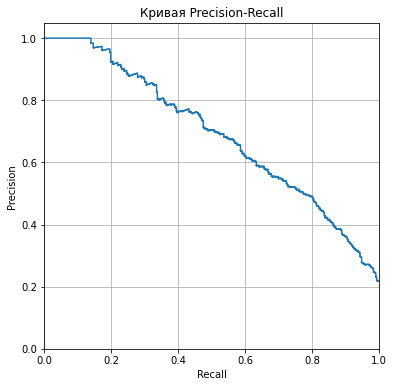

In [58]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.grid()
plt.show() 

В нашем случае значение порога равное 0.5 обеспечивает максимальное значение целевой метрики F1, найденное в предыдущем разделе.

# Вывод<a id="end_3"></a>

Проведено сравнение следующих моделей:
+ Логистическая регрессия
+ Случайный лес
+ Градиентный бустинг
+ XGBoost
+ CatBoost  

для различных вариантов балансировки классов:
+ без балансировки классов
+ баланс классов посредством гиперпараметров
+ upsampling
+ downsampling

Все модели на базе бустинга показывают значение целевой метрики F1 в пределах 0.6-0.62, что удовлетворяет минимально допустимому уровню по условиям проекта.  
В качестве итоговой модели выбрана модель СatBoost, со значениями F1=0.62, AUC-ROC=0.86  
На данной модели будет проведено итоговое тестирование.


# 4. Тестирование модели<a id="4"></a>

Проведем тестирование модели.
Объединим обучающую и валидационную выборки, для получения бОльшего объема, обучим на них модель, затем проверим модель на тестовой выборке.  
Сравним результаты метрик с полученными в разделе "Улучшение качества модели".

In [59]:
features_res = pd.concat([features_train, features_valid], ignore_index=True)
target_res = pd.concat([target_train, target_valid], ignore_index=True)

model = CatBoostClassifier(random_state=12345, auto_class_weights='Balanced') 
model.fit(features_res, target_res) 
predictions_test = model.predict(features_test)

precision = precision_score(target_test, predictions_test)
recall = recall_score(target_test, predictions_test)
f1_score = (2 * precision * recall) / (precision + recall)
print(classification_report(target_test, predictions_test))
print('Значение F1:', f1_score)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)
print('Значение AUC-ROC', roc_auc)



Learning rate set to 0.025035
0:	learn: 0.6813394	total: 11.6ms	remaining: 11.6s
1:	learn: 0.6704138	total: 19.6ms	remaining: 9.76s
2:	learn: 0.6582550	total: 27.5ms	remaining: 9.14s
3:	learn: 0.6504714	total: 34.3ms	remaining: 8.54s
4:	learn: 0.6410897	total: 41.8ms	remaining: 8.32s
5:	learn: 0.6315901	total: 49.3ms	remaining: 8.17s
6:	learn: 0.6228282	total: 56.9ms	remaining: 8.07s
7:	learn: 0.6167210	total: 63.9ms	remaining: 7.93s
8:	learn: 0.6106640	total: 71.7ms	remaining: 7.89s
9:	learn: 0.6032560	total: 79.1ms	remaining: 7.83s
10:	learn: 0.5950902	total: 86.7ms	remaining: 7.8s
11:	learn: 0.5885999	total: 94.2ms	remaining: 7.75s
12:	learn: 0.5829570	total: 101ms	remaining: 7.69s
13:	learn: 0.5766602	total: 109ms	remaining: 7.66s
14:	learn: 0.5720413	total: 116ms	remaining: 7.63s
15:	learn: 0.5662783	total: 124ms	remaining: 7.6s
16:	learn: 0.5616660	total: 131ms	remaining: 7.57s
17:	learn: 0.5573371	total: 138ms	remaining: 7.54s
18:	learn: 0.5522054	total: 146ms	remaining: 7.53s
1

## Вывод

Проведенное тестирование модели показало значение метрик (F1=0.62, AUC-ROC=0.86), аналогичное значениям на валидационной выборке, что говорит об отсутствии переобучения модели.  


# Общий вывод<a id="5"></a>

В рамках проекта были исследованы различные модели классификации для несбалансированной выборки.  
Была проведена предварительная подготовка данных, кодирование, масштабирование признаков.
Проведено сравнение следующих моделей:
+ Логистическая регрессия
+ Случайный лес
+ Градиентный бустинг
+ XGBoost
+ CatBoost  

для различных вариантов балансировки классов:
+ без балансировки классов
+ баланс классов посредством гиперпараметров
+ upsampling
+ downsampling

Анализ показал, что использование гиперпараметров модели обеспечивает лучшее качество балансировки признаков, по сравнению с апсэмлингом и даунсэмплингом.  
Все модели на основе бустинга показали примерно одинаковое значение целевой метрики F1. Максимальное значение F1=0.62 обеспечила модель CatBoost, как на валидационной, так и на тестовой выборках, что говорит об отсутствии переобучения модели.  
Максимальное значение AUC-ROC для выбранной модели составило 0.86, что значительно выше аналогичного показателя для случайной модели.  
Резюмируя, полученную модель можно считать удовлетворяющей требованиям задания и ее можно рекомендовать для предсказания вероятности ухода клиента из банка